![logo](https://www.databolt.tech/images/logo.png)
Accelerate data science [www.databolt.tech](https://www.databolt.tech) | [github.com/d6t/d6t-python](https://github.com/d6t/d6t-python)


# DATA SCIENCE PROJECT TEMPLATES

## Regression
### ISLR advertising data

In [1]:
# processing
import d6tflow, luigi, d6tpipe
import pandas as pd
import numpy as np
import pathlib

# viz
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import cross_validate
import lightgbm
#lightgbm.LGBMRegressor
import shap
#shap.initjs()

# project
# import cfg, tasks
# import importlib # optional
# importlib.reload(cfg)
# importlib.reload(tasks)
# importlib.reload(visualize)


Welcome to d6tflow!
Welcome to d6tpipe!


## preprocessing

In [2]:
import d6tflow.pipes

d6tflow.pipes.init('intro-stat-learning',profile='default', reset=True) #, local_pipe=True
pipe = d6tflow.pipes.get_pipe()
pipe.pull()

Connected to https://pipe.databolt.tech as citynorman
Successfully connected to pipe intro-stat-learning.  Read only access
pulling: 0.00MB


0it [00:00, ?it/s]


[]

In [3]:
print('where files are stored:',pipe.dirpath)

where files are stored: C:\Users\deepmind\d6tpipe\files\default\intro-stat-learning


In [4]:
# tasks

class TaskProcessRawData(d6tflow.tasks.TaskPqPandas):

    def run(self):
        pipe=d6tpipe.PipeLocal('intro-stat-learning')
        df = pd.read_csv(pipe.dirpath/'Advertising.csv', usecols=[1,2,3,4])
        df = df.rename(columns={'sales':'Sales'})
        self.save(df)

@d6tflow.requires(TaskProcessRawData)
class TaskFeatures(d6tflow.tasks.TaskPqPandas):
    interaction = luigi.BoolParameter(default=False)
    
    def run(self):
        df = self.inputLoad()
        df['target']=df['Sales']
        if self.interaction:
            df['tv_radio']=df['TV']*df_ad['radio']
        self.save(df)

In [5]:
d6tflow.run([TaskFeatures()],forced_all=True,confirm=False)
df_train = TaskFeatures().outputLoad()

INFO: Informed scheduler that task   TaskFeatures_False_6094d22e10   has status   PENDING
INFO:luigi-interface:Informed scheduler that task   TaskFeatures_False_6094d22e10   has status   PENDING
INFO: Informed scheduler that task   TaskProcessRawData__99914b932b   has status   DONE
INFO:luigi-interface:Informed scheduler that task   TaskProcessRawData__99914b932b   has status   DONE
INFO: Done scheduling tasks
INFO:luigi-interface:Done scheduling tasks
INFO: Running Worker with 1 processes
INFO:luigi-interface:Running Worker with 1 processes
INFO: [pid 14592] Worker Worker(salt=853427592, workers=1, host=DESKTOP-D9OFHV1, username=deepmind, pid=14592) running   TaskFeatures(interaction=False)
INFO:luigi-interface:[pid 14592] Worker Worker(salt=853427592, workers=1, host=DESKTOP-D9OFHV1, username=deepmind, pid=14592) running   TaskFeatures(interaction=False)
INFO: [pid 14592] Worker Worker(salt=853427592, workers=1, host=DESKTOP-D9OFHV1, username=deepmind, pid=14592) done      TaskFeatur

In [6]:
df_train = TaskFeatures().outputLoad()

In [7]:
cfg_col_X = ['TV', 'radio', 'newspaper']
cfg_col_Y = 'target'

In [8]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

## data overview

* general structure  
* summary visualizations
* visual predictive analysis
    * naive baseline models

In [9]:
print(df_train.columns)

Index(['TV', 'radio', 'newspaper', 'Sales', 'target'], dtype='object')


In [10]:
df_train.head()

,TV,radio,newspaper,Sales,target
0,230.1,37.8,69.2,22.1,22.1
1,44.5,39.3,45.1,10.4,10.4
2,17.2,45.9,69.3,9.3,9.3
3,151.5,41.3,58.5,18.5,18.5
4,180.8,10.8,58.4,12.9,12.9


In [11]:
print('observations and type')
df_train.info()

observations and type
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
TV           200 non-null float64
radio        200 non-null float64
newspaper    200 non-null float64
Sales        200 non-null float64
target       200 non-null float64
dtypes: float64(5)
memory usage: 7.9 KB


In [12]:
print('missing values')
df_train.apply(lambda x: x.isna().sum()/len(x))

missing values


TV           0.0
radio        0.0
newspaper    0.0
Sales        0.0
target       0.0
dtype: float64

In [13]:
df_train.describe().round(2)

,TV,radio,newspaper,Sales,target
count,200.00,200.00,200.00,200.00,200.00
mean,147.04,23.26,30.55,14.02,14.02
std,85.85,14.85,21.78,5.22,5.22
min,0.70,0.00,0.30,1.60,1.60
25%,74.38,9.98,12.75,10.38,10.38
50%,149.75,22.90,25.75,12.90,12.90
75%,218.82,36.52,45.10,17.40,17.40
max,296.40,49.60,114.00,27.00,27.00


### distribution of target variable

In [1]:
sns.distplot(df_train[cfg_col_Y]).set_title(cfg_col_Y);

NameError: name 'sns' is not defined

### distribution of input variables

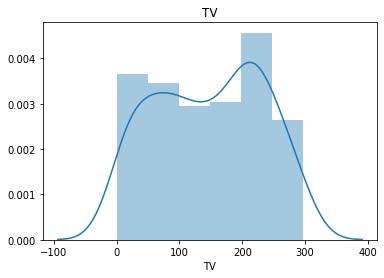

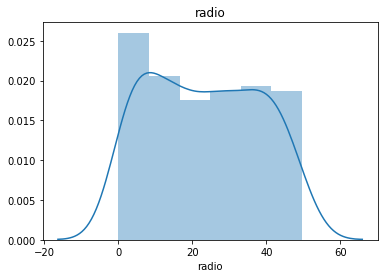

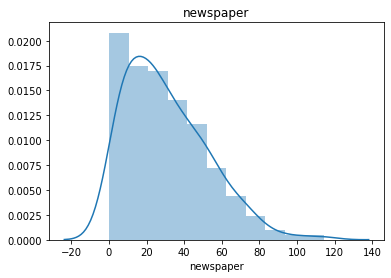

In [15]:
for icol in cfg_col_X:
    plt.figure();
    sns.distplot(df_train[icol]).set_title(icol);


### relation of inut variables to target variable

<Figure size 432x288 with 0 Axes>

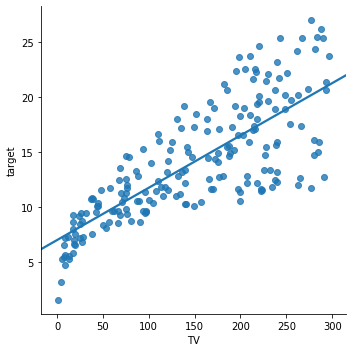

<Figure size 432x288 with 0 Axes>

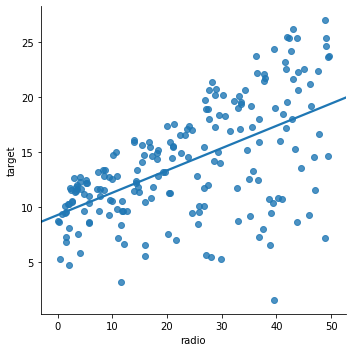

<Figure size 432x288 with 0 Axes>

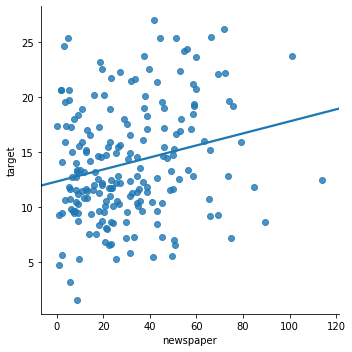

In [16]:
for icol in cfg_col_X:
    plt.figure();
    sns.lmplot(x=icol, y=cfg_col_Y, data=df_train, ci=None);

## model training

In [17]:
df_trainX, df_trainY = df_train[cfg_col_X], df_train[cfg_col_Y]

In [18]:
df_train['target_naive1']=df_train['target'].mean()

In [19]:
mod_ols = sm.OLS(df_trainY,sm.add_constant(df_trainX))

res_ols = mod_ols.fit()
print(res_ols.summary())
df_train['target_ols']=res_ols.predict()

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Sun, 31 May 2020   Prob (F-statistic):           1.58e-96
Time:                        10:50:47   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.0

In [20]:
from sklearn.linear_model import LinearRegression

mod_skols = LinearRegression()
mod_skols.fit(df_trainX,df_trainY)
df_train['target_skols']=mod_skols.predict(df_trainX)

In [21]:
mod_lgbm = lightgbm.LGBMRegressor(max_depth=2,learning_rate=0.1,n_estimators=100,reg_alpha=1.0)
mod_lgbm.fit(df_trainX,df_trainY)
df_train['target_lgbm']=mod_lgbm.predict(df_trainX)

## model evaluation

### prediction errors: in-sample

In [22]:
print('naive mean',mean_squared_error(df_train[cfg_col_Y],df_train['target_naive1']))
print('ols',mean_squared_error(df_train[cfg_col_Y],df_train['target_skols']))
print('gbm',mean_squared_error(df_train[cfg_col_Y],df_train['target_lgbm']))

naive mean 27.085743750000002
ols 2.784126314510936
gbm 0.4284192451295194


### prediction errors: cross-validation

In [23]:
print('ols',-cross_validate(mod_skols, df_trainX, df_trainY, return_train_score=False, scoring=('r2', 'neg_mean_squared_error'), cv=10)['test_neg_mean_squared_error'].mean())
print('gbm',-cross_validate(mod_lgbm, df_trainX, df_trainY, return_train_score=False, scoring=('r2', 'neg_mean_squared_error'), cv=10)['test_neg_mean_squared_error'].mean())

ols 3.059967618118513
gbm 1.0701552068792164


## model interpretation

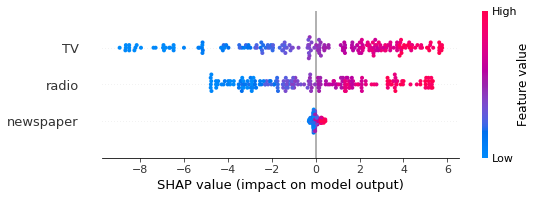

In [24]:
explainer = shap.TreeExplainer(mod_lgbm, df_trainX)
shap_values = explainer.shap_values(df_trainX)

shap.summary_plot(shap_values, df_trainX)


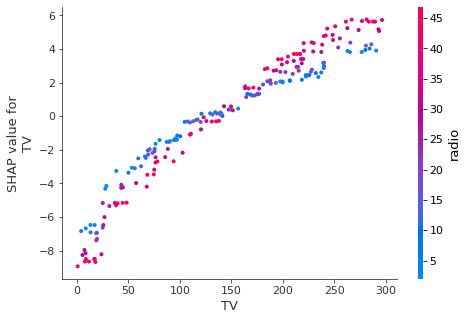

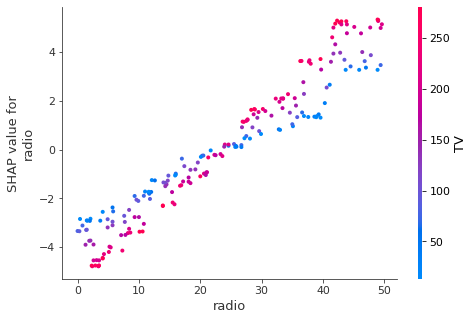

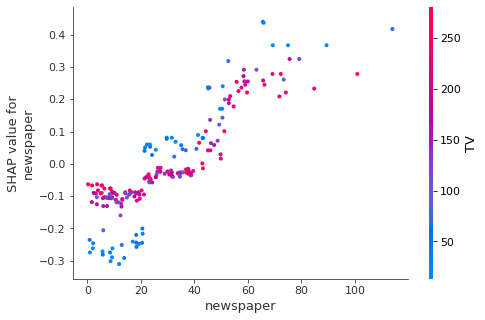

In [25]:
for col in cfg_col_X:
    shap.dependence_plot(col, shap_values, df_trainX)#,interaction_index=None)

In [26]:
dict(zip(cfg_col_X,range(len(cfg_col_X))))

{'TV': 0, 'radio': 1, 'newspaper': 2}

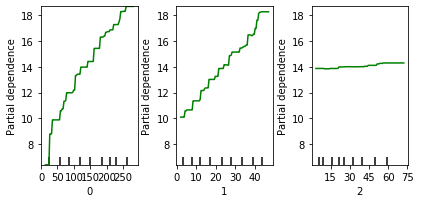

In [27]:
plot_partial_dependence(mod_lgbm, df_trainX, range(len(cfg_col_X))) 